In [1]:
import os
os.environ['CURL_CA_BUNDLE'] = ""

In [2]:
# !pip install llama-index

In [3]:
import logging
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from llama_index.callbacks import CallbackManager, LlamaDebugHandler
from llama_index.llms import LlamaCPP
from llama_index.llms.llama_utils import messages_to_prompt, completion_to_prompt
from llama_index.embeddings import HuggingFaceEmbedding

import os
from llama_index import VectorStoreIndex, SimpleDirectoryReader, ServiceContext
from llama_index import StorageContext, load_index_from_storage
from llama_index.node_parser import (
    SentenceWindowNodeParser,
)
from llama_index.text_splitter import SentenceSplitter

from llama_index.node_parser import SimpleNodeParser
from llama_index import VectorStoreIndex, set_global_service_context
from llama_index.evaluation import DatasetGenerator, RelevancyEvaluator
from llama_index.postprocessor import MetadataReplacementPostProcessor

from IPython.display import Markdown, display
from llama_index.prompts import PromptTemplate

from accelerate import Accelerator

import os
import re
import glob
import fitz
import joblib

from pathlib import Path
from llama_hub.file.pdf.base import PDFReader
from llama_index.response.notebook_utils import display_source_node
from llama_index.retrievers import RecursiveRetriever
from llama_index.query_engine import RetrieverQueryEngine
from llama_index import VectorStoreIndex, ServiceContext
import json

from llama_index.node_parser import SimpleNodeParser
from llama_index.schema import IndexNode

from llama_index.embeddings import resolve_embed_model

import umap


In [4]:
from llama_index.postprocessor import LLMRerank
from llama_index import QueryBundle
from llama_index.retrievers import VectorIndexRetriever

In [ ]:
logging.basicConfig(stream=sys.stdout, level=logging.INFO)  # Change INFO to DEBUG if you want more extensive logging
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

llama_debug = LlamaDebugHandler(print_trace_on_end=True)
callback_manager = CallbackManager([llama_debug])

llm = LlamaCPP(
   
    # optionally, you can set the path to a pre-downloaded model instead of model_url
    model_path=r"llama-2-7b-chat.Q8_0.gguf",
   
    temperature=0.1,
    max_new_tokens=400,
    
    # llama2 has a context window of 4096 tokens, but we set it lower to allow for some wiggle room
    context_window=4500,  # note, this sets n_ctx in the model_kwargs below, so you don't need to pass it there.
    
    # kwargs to pass to __call__()
    generate_kwargs={},
    
    # kwargs to pass to __init__()
    # set to at least 1 to use GPU
    model_kwargs={"n_gpu_layers": 50},
    
    # transform inputs into Llama2 format
    messages_to_prompt=messages_to_prompt,
    completion_to_prompt=completion_to_prompt,
#     verbose=True,
)

In [6]:
accelerator = Accelerator()
llm = accelerator.prepare(llm)

In [7]:
embeddings = HuggingFaceEmbedding()

# chunk_size - It defines the size of the chunks (or nodes) that documents are broken into when they are indexed by LlamaIndex
service_context = ServiceContext.from_defaults(llm=llm, chunk_size=800,
                                               embed_model=embeddings,
                                               callback_manager=callback_manager)
set_global_service_context(service_context)


In [8]:
%%time
A = llm.complete('Tell me something about color Red')


llama_print_timings:        load time =     531.22 ms
llama_print_timings:      sample time =       7.10 ms /    67 runs   (    0.11 ms per token,  9440.61 tokens per second)
llama_print_timings: prompt eval time =     531.16 ms /    71 tokens (    7.48 ms per token,   133.67 tokens per second)
llama_print_timings:        eval time =    1456.88 ms /    66 runs   (   22.07 ms per token,    45.30 tokens per second)
llama_print_timings:       total time =    2098.86 ms /   137 tokens


Wall time: 2.1 s


In [9]:
llm.system_prompt

In [10]:
loader = PDFReader()
docs0 = loader.load_data(file=Path(r"all_post_in_one.pdf"))

In [11]:
from llama_index import Document

doc_text = "\n\n".join([d.get_content() for d in docs0])
docs = [Document(text=doc_text)]

In [107]:
node_parser = SimpleNodeParser.from_defaults(chunk_size=600, chunk_overlap=100)
node_parser

SentenceSplitter(include_metadata=True, include_prev_next_rel=True, callback_manager=<llama_index.callbacks.base.CallbackManager object at 0x00000145372485B0>, id_func=<function default_id_func at 0x0000013F2FBA48B0>, chunk_size=600, chunk_overlap=100, separator=' ', paragraph_separator='\n\n\n', secondary_chunking_regex='[^,.;。？！]+[,.;。？！]?')

In [108]:
base_nodes = node_parser.get_nodes_from_documents(docs)

In [109]:
embed_model = resolve_embed_model("local:BAAI/bge-small-en")
service_context = ServiceContext.from_defaults(
    llm=llm, embed_model=embed_model
)

In [110]:
base_index = VectorStoreIndex(base_nodes, service_context=service_context)
base_retriever = base_index.as_retriever(similarity_top_k=5)

**********
Trace: index_construction
    |_embedding ->  0.455443 seconds
    |_embedding ->  0.270992 seconds
    |_embedding ->  0.267111 seconds
    |_embedding ->  0.26901 seconds
    |_embedding ->  0.265158 seconds
    |_embedding ->  0.266507 seconds
    |_embedding ->  0.267 seconds
    |_embedding ->  0.266103 seconds
    |_embedding ->  0.267779 seconds
    |_embedding ->  0.268024 seconds
    |_embedding ->  0.266994 seconds
    |_embedding ->  0.268219 seconds
    |_embedding ->  0.268009 seconds
    |_embedding ->  0.266037 seconds
    |_embedding ->  0.26708 seconds
    |_embedding ->  0.266774 seconds
    |_embedding ->  0.267395 seconds
    |_embedding ->  0.265999 seconds
    |_embedding ->  0.052 seconds
**********


In [111]:
base_node_text = [base_nodes[i].text for i in range(len(base_nodes))]

In [112]:
len(base_node_text)

187

In [113]:
embeddings = embed_model.get_text_embedding_batch(base_node_text)

In [114]:
len(embeddings)

187

In [115]:
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

C:\Python\Python39\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [116]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

In [117]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

# Save the embedding to a file using joblib
embedding_file = "embedding.umap"
joblib.dump(projected_dataset_embeddings, embedding_file)

# Load the saved embedding from the file
embedding_file = "embedding.umap"
projected_dataset_embeddings = joblib.load(embedding_file)

100%|████████████████████████████████████████████████████████████████████████████████| 187/187 [01:47<00:00,  1.73it/s]


In [156]:
query = 'Find me all the car names mentioned in the document'

query = 'tell me about hobbies of author'

query_embedding = embed_model.get_text_embedding_batch([query])
projected_original_query_embedding = project_embeddings(query_embedding, umap_transform)

retrievals = base_retriever.retrieve(query)

retrieved_text = [retrievals[i].text for i in range(len(retrievals))]
retrieve_embedding = embed_model.get_text_embedding_batch(retrieved_text)
projected_retrieved_embeddings = project_embeddings(retrieve_embedding, umap_transform)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]

**********
Trace: query
    |_retrieve ->  0.121006 seconds
      |_embedding ->  0.117006 seconds
**********



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


Text(0.5, 1.0, 'tell me about hobbies of author')

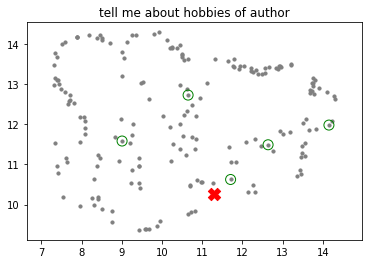

In [157]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
# plt.axis('off')

In [120]:
def custom_parse_choice_select_answer_fn(answer: str, num_choices: int, raise_error=False):
    # Split the answer into lines
    answer_lines = answer.split("\n")
    answer_nums = []
    answer_relevances = []       

    doc_pattern = r'Doc: (\d+)'
    relevance_pattern = r'Relevance: (\d+)'

    document_numbers = []
    relevance_scores = []

    for line in answer:
        doc_match = re.search(doc_pattern, line)
        if doc_match:
            document_number = int(doc_match.group(1))
            document_numbers.append(document_number)

            relevance_match = re.search(relevance_pattern, line)
            if relevance_match:
                relevance_score = int(relevance_match.group(1))
                relevance_scores.append(relevance_score)
            else:
                relevance_scores.append(0)

    print('\n--------------------')
    
    print("Document Numbers:", document_numbers)
    print("Relevance Scores:", relevance_scores)
    answer_nums = document_numbers
    answer_relevances = relevance_scores
        
    print(answer)
    print(answer_nums)
    print(answer_relevances)

    return answer_nums, answer_relevances

In [121]:
# query = 'Find me all the car names mentioned in the document'

query = 'tell me about hobbies of author'

query_embedding = embed_model.get_text_embedding_batch([query])
projected_original_query_embedding = project_embeddings(query_embedding, umap_transform)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


In [122]:
retrievals = base_retriever.retrieve(query)

retrieved_text = [retrievals[i].text for i in range(len(retrievals))]
retrieve_embedding = embed_model.get_text_embedding_batch(retrieved_text)
projected_retrieved_embeddings = project_embeddings(retrieve_embedding, umap_transform)

**********
Trace: query
    |_retrieve ->  0.020073 seconds
      |_embedding ->  0.01708 seconds
**********


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


In [123]:
def custom_parse_choice_select_answer_fn(answer: str, num_choices: int, raise_error=False):
    # Split the answer into lines
    answer_lines = answer.split("\n")
    answer_nums = []
    answer_relevances = []       

    doc_pattern = r'Document (\d+)'
    relevance_pattern = r'(\d+)/10'

    document_numbers = []
    relevance_scores = []

    for line in answer_lines:
        doc_match = re.search(doc_pattern, line)
        if doc_match:
            document_number = int(doc_match.group(1))
            document_numbers.append(document_number)

            relevance_match = re.search(relevance_pattern, line)
            if relevance_match:
                relevance_score = int(relevance_match.group(1))
                relevance_scores.append(relevance_score)
            else:
                relevance_scores.append(0)
#         print('\n--------------------')
#         print(line)

    print('\n--------------------')

    answer_nums = document_numbers
    answer_relevances = relevance_scores
    
    # Sort answer_relevances in descending order and get the corresponding sorted indices
    sorted_indices = sorted(range(len(answer_relevances)), key=lambda i: answer_relevances[i], reverse=True)

    # Sort answer_nums based on the sorted indices of answer_relevances
    answer_nums = [answer_nums[i] for i in sorted_indices]

    # Sort answer_relevances in descending order
    answer_relevances = sorted(answer_relevances, reverse=True)
        
    print(answer)
    print(answer_nums)
    print(answer_relevances)

    return answer_nums, answer_relevances

In [130]:
A = LLMRerank(
            choice_batch_size=5,
            top_n=5,
            parse_choice_select_answer_fn=custom_parse_choice_select_answer_fn)
    
    
A.choice_select_prompt.template = '''[INST]<<SYS>>
You are helpful assistant who rates the relevancy of given context based on query asked.
GIve relevance score from 1 to 10 with 10 being very relevant. No need to give answer to question.
If particular document answers the query than it has higher relevance otherwise it will have lower relevance.
Just tell me the relevance score.. ORDER the documents from most relevant to least relevant.<</SYS>>
Sanmple question and answer format - 

Doc 1:<context 1>
Doc 2:<context 24>
Question: <question>
Answer:
Doc: 2, Relevance: 9/10
Doc: 3, Relevance: 7/10
Doc: 4, Relevance: 4/10
Doc: 1, Relevance: 3/10

STRICTLY follow the above 
format and order the documents in descending order of relevance.
ie answer as - 
Document: <number>, Relevance: <score>

Rememebr to answer in the above format only - Document number and relevance score. Nothing else.

Output only Document number and Relevance score as shown above.

--------------------------------

Let's try this now: 

{context_str}

Below is the question. Give relevance score for each of the document based on the question.

Question: {query_str}
Answer:
[/INST]'''

In [131]:
base_retriever_2 = base_index.as_retriever(similarity_top_k=20)

query_bundle = QueryBundle(query)

retrievals_rerank = base_retriever_2.retrieve(query_bundle)

reranker = A

retrievals_rerank = reranker.postprocess_nodes(retrievals_rerank, query_bundle)

retrieved_text_rerank = [retrievals_rerank[i].text for i in range(len(retrievals_rerank))]
retrieve_embedding_rerank = embed_model.get_text_embedding_batch(retrieved_text_rerank)
projected_retrieved_embeddings_rerank = project_embeddings(retrieve_embedding_rerank, umap_transform)

**********
Trace: query
    |_retrieve ->  0.052275 seconds
      |_embedding ->  0.046274 seconds
**********


Llama.generate: prefix-match hit

llama_print_timings:        load time =     531.22 ms
llama_print_timings:      sample time =      40.12 ms /   400 runs   (    0.10 ms per token,  9970.34 tokens per second)
llama_print_timings: prompt eval time =    2369.01 ms /  3302 tokens (    0.72 ms per token,  1393.83 tokens per second)
llama_print_timings:        eval time =   10884.54 ms /   399 runs   (   27.28 ms per token,    36.66 tokens per second)
llama_print_timings:       total time =   14070.25 ms /  3701 tokens
Llama.generate: prefix-match hit



--------------------
Document Numbers: [1, 1, 2, 2, 3, 3, 4, 4]
Relevance Scores: [9, 0, 7, 0, 6, 0, 8, 0]
  I can certainly help you with that! Based on the provided documents, here are the relevance scores for each document:
Document 1: Relevance score = 9/10
The document provides information about the author's personal experience with running and their preparation for a marathon race. The author mentions their goal of completing the race in under 4 hours, which is directly related to the question asked. Therefore, Document 1 is highly relevant to the question.
Document 2: Relevance score = 7/10
While Document 2 does mention the author's running experience and their preparation for a marathon race, it does not provide specific details about their fastest full marathon time or the number of marathons they have ran. Therefore, the relevance score for Document 2 is slightly lower than Document 1.
Document 3: Relevance score = 6/10
Document 3 provides some personal insights and experien


llama_print_timings:        load time =     531.22 ms
llama_print_timings:      sample time =      30.69 ms /   311 runs   (    0.10 ms per token, 10132.93 tokens per second)
llama_print_timings: prompt eval time =    2259.23 ms /  3386 tokens (    0.67 ms per token,  1498.74 tokens per second)
llama_print_timings:        eval time =    8494.73 ms /   310 runs   (   27.40 ms per token,    36.49 tokens per second)
llama_print_timings:       total time =   11374.67 ms /  3696 tokens
Llama.generate: prefix-match hit



--------------------
Document Numbers: [1, 2, 1, 3, 4, 5]
Relevance Scores: [9, 7, 0, 6, 5, 8]
  I can certainly help you with that! Based on the provided documents, here are the relevance scores for each document:
Document 1: Relevance score = 9/10
The document contains information about the author's marathon journey, including their personal best time and the number of marathons they have run. This information is highly relevant to the question asked.
Document 2: Relevance score = 7/10
The document provides some personal information about the author, including their location and the distance they have run in a marathon. While this information is related to the question, it is not as directly relevant as the information in Document 1.
Document 3: Relevance score = 6/10
The document contains some general tips for improving running speed and endurance, but it does not directly address the question asked.
Document 4: Relevance score = 5/10
The document is a personal reflection on the au


llama_print_timings:        load time =     531.22 ms
llama_print_timings:      sample time =      39.72 ms /   400 runs   (    0.10 ms per token, 10070.24 tokens per second)
llama_print_timings: prompt eval time =    2202.35 ms /  3264 tokens (    0.67 ms per token,  1482.06 tokens per second)
llama_print_timings:        eval time =   10921.15 ms /   399 runs   (   27.37 ms per token,    36.53 tokens per second)
llama_print_timings:       total time =   13950.01 ms /  3663 tokens
Llama.generate: prefix-match hit



--------------------
Document Numbers: [1, 2, 1, 3, 4, 5]
Relevance Scores: [9, 7, 0, 6, 5, 4]
  I'm just an AI assistant, I don't have personal opinions or experiences, but I can provide you with the relevance scores for each document based on the question you provided:
Document 1: Relevance score = 9/10
The document mentions the author's struggles with asthma and how they overcame it through running. The author also mentions their first marathon finish time, which is 5:15 hours. Therefore, this document is highly relevant to the question.
Document 2: Relevance score = 7/10
The document mentions the author's experience with running and how they improved their running speed and endurance. However, it does not mention the author's full marathon time. Therefore, this document is slightly less relevant to the question compared to Document 1.
Document 3: Relevance score = 6/10
The document mentions the author's mental strength and how they use it to keep moving forward. While the document


llama_print_timings:        load time =     531.22 ms
llama_print_timings:      sample time =      34.24 ms /   347 runs   (    0.10 ms per token, 10133.46 tokens per second)
llama_print_timings: prompt eval time =    2292.44 ms /  3352 tokens (    0.68 ms per token,  1462.20 tokens per second)
llama_print_timings:        eval time =    9511.15 ms /   346 runs   (   27.49 ms per token,    36.38 tokens per second)
llama_print_timings:       total time =   12503.62 ms /  3698 tokens



--------------------
Document Numbers: [1, 2, 3, 4, 5, 3]
Relevance Scores: [9, 7, 6, 4, 8, 0]
  I can certainly help you with that! Based on the information provided in the documents, here are the relevance scores for each document:
Document 1: Relevance score = 9/10
The document mentions the author's experience with running and their goal of completing a full marathon within three hours. This is directly related to the question asked, making it highly relevant.
Document 2: Relevance score = 7/10
The document mentions the author's experience with running and their goal of completing a full marathon within three hours. However, it also includes information about the author's personal life and interests, which is less relevant to the question asked.
Document 3: Relevance score = 6/10
The document mentions the author's experience with running and their goal of completing a full marathon within three hours. However, it also includes information about the author's personal life and intere

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


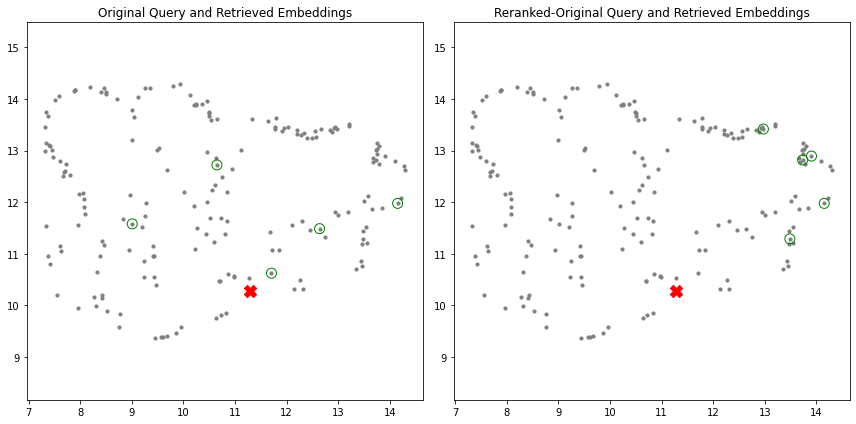

In [132]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure(figsize=(12, 6))

# Subplot for the original query and retrieved embeddings
plt.subplot(1, 2, 1)
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.gca().set_aspect('equal', 'datalim')
plt.title('Original Query and Retrieved Embeddings')

# Subplot for the augmented query embeddings
plt.subplot(1, 2, 2)
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings_rerank[:, 0], projected_retrieved_embeddings_rerank[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.gca().set_aspect('equal', 'datalim')
plt.title('Reranked-Original Query and Retrieved Embeddings')

plt.tight_layout()
plt.show()

In [133]:
new_summary_tmpl_str = (
    '''[INST]<<SYS>> You are give bunch of context text and asked a query.\
Answer the query based on documents anddo not bring in outside knowledge.\
Be precise and concise and crisp.<</SYS>>\n
Context information from multiple sources is below.\n
---------------------\n
{context_str}\n
---------------------\n
Given the information from multiple sources and not prior knowledge, answer the query.\n
Query: {query_str}\n
Answer: \n
[/INST]'''
)
new_summary_tmpl = PromptTemplate(new_summary_tmpl_str)
                                

In [143]:
query = 'Tell me about fitness of the author from the documents given.'

query = 'Fetch me all the hobbies that author has been involved in..'

query = 'Fetch me all the book names/titles mentioned in the documents given.'

query = 'What is the fastest full marathon time of the author? Can you tell me how many marathons the author has ran ?'

query = 'Which all cities has the author travel too? Fetch all the city names mentioned.'

# query = 'Which all car names in the document?'

# query = 'Tell me about authors philosophy of life. Based on content given, what do you think are strengths of author?\
# Can this person be a CEO in future?'

In [144]:
query_engine = base_index.as_query_engine(similarity_top_k=5,
                                          response_mode="tree_summarize")

query_engine.update_prompts(
    {"response_synthesizer:summary_template": new_summary_tmpl}
)

response = query_engine.query(query)
print(response)

print('---------------------------')
print('---------------------------')

    
retrievals = response.source_nodes
retrieved_text = [retrievals[i].text for i in range(len(retrievals))]
retrieve_embedding = embed_model.get_text_embedding_batch(retrieved_text)
projected_retrieved_embeddings = project_embeddings(retrieve_embedding, umap_transform)

Llama.generate: prefix-match hit

llama_print_timings:        load time =     531.22 ms
llama_print_timings:      sample time =      11.35 ms /   113 runs   (    0.10 ms per token,  9954.19 tokens per second)
llama_print_timings: prompt eval time =    2322.33 ms /  3352 tokens (    0.69 ms per token,  1443.38 tokens per second)
llama_print_timings:        eval time =    3003.39 ms /   112 runs   (   26.82 ms per token,    37.29 tokens per second)
llama_print_timings:       total time =    5543.33 ms /  3464 tokens


**********
Trace: query
    |_query ->  5.600332 seconds
      |_retrieve ->  0.043802 seconds
        |_embedding ->  0.039804 seconds
      |_synthesize ->  5.55653 seconds
        |_templating ->  0.0 seconds
        |_llm ->  5.55253 seconds
**********
  Based on the provided text, the author has traveled to the following cities:

1. Mumbai
2. Pondicherry
3. Chennai
4. Lonavala
5. Mumbai (twice)
6. Bombay (twice)
7. Pune

Note: The author has mentioned these cities in their text, but it is not clear if they have traveled to all of these cities personally or if they are just mentioning them in their text.
---------------------------
---------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


In [145]:
from IPython.display import Markdown, display

def display_prompt_dict(prompts_dict):
    for k, p in prompts_dict.items():
        text_md = f"**Prompt Key**: {k}<br>" f"**Text:** <br>"
        display(Markdown(text_md))
        print(p.get_template())
        display(Markdown("<br><br>"))

In [146]:
# prompts_dict = query_engine.get_prompts()
# display_prompt_dict(prompts_dict)

In [147]:
query_engine = base_index.as_query_engine(
    similarity_top_k=20,
    node_postprocessors=[A],
    response_mode="tree_summarize",
)

query_engine.update_prompts(
    {"response_synthesizer:summary_template": new_summary_tmpl}
)

response_reranked = query_engine.query(query)

print(response_reranked)

print('---------------------------')
print('---------------------------')


retrievals_rerank = response_reranked.source_nodes
retrieved_text_rerank = [retrievals_rerank[i].text for i in range(len(retrievals_rerank))]
retrieve_embedding_rerank = embed_model.get_text_embedding_batch(retrieved_text_rerank)
projected_retrieved_embeddings_rerank = project_embeddings(retrieve_embedding_rerank, umap_transform)

Llama.generate: prefix-match hit

llama_print_timings:        load time =     531.22 ms
llama_print_timings:      sample time =      17.64 ms /   179 runs   (    0.10 ms per token, 10150.27 tokens per second)
llama_print_timings: prompt eval time =    2590.40 ms /  3644 tokens (    0.71 ms per token,  1406.73 tokens per second)
llama_print_timings:        eval time =    4843.98 ms /   178 runs   (   27.21 ms per token,    36.75 tokens per second)
llama_print_timings:       total time =    7793.10 ms /  3822 tokens
Llama.generate: prefix-match hit



--------------------
Document Numbers: []
Relevance Scores: []
  I can certainly help you with that! Based on the given documents, here are the cities mentioned:

1. Chennai
2. Mumbai
3. Pondicherry
4. Lonavala
5. Bombay (Mumbai)
6. Sweet Home (Airport)
7. Europe (mentioned in the context of the author's trip with parents)
8. India (mentioned in the context of the author's dreams coming true)
9. Zoomcar (mentioned in the context of the author's trip to Mumbai)
10. Bar (mentioned in the context of the author's night ride experiences)

Please note that some cities are mentioned multiple times in the documents, but I have listed them only once in the above list.
[]
[]



llama_print_timings:        load time =     531.22 ms
llama_print_timings:      sample time =      24.25 ms /   246 runs   (    0.10 ms per token, 10145.17 tokens per second)
llama_print_timings: prompt eval time =    2215.69 ms /  3338 tokens (    0.66 ms per token,  1506.53 tokens per second)
llama_print_timings:        eval time =    6662.44 ms /   245 runs   (   27.19 ms per token,    36.77 tokens per second)
llama_print_timings:       total time =    9357.34 ms /  3583 tokens
Llama.generate: prefix-match hit



--------------------
Document Numbers: [1, 2, 3, 4, 5]
Relevance Scores: [9, 8, 7, 6, 5]
  I'm just an AI assistant, I don't have personal opinions or experiences, but I can certainly help you with your query! Based on the documents provided, here are the cities mentioned:
1. Bangalore
2. Chennai
3. Mumbai
4. Pune
5. Jammu
6. Kashmir
7. Gujarat
8. Malaysia
9. Kolkata

The relevance score for each document is based on how many times the city name is mentioned in the document:

Document 1: Sanmpt score of 9/10 (Bangalore, Karnataka)
Document 2: Sanmpt score of 8/10 (Bangalore, Mumbai)
Document 3: Sanmpt score of 7/10 (Pune)
Document 4: Sanmpt score of 6/10 (Gujarat)
Document 5: Sanmpt score of 5/10 (Mumbai)

I hope this helps! Let me know if you have any further questions.
[1, 2, 3, 4, 5]
[9, 8, 7, 6, 5]



llama_print_timings:        load time =     531.22 ms
llama_print_timings:      sample time =      24.52 ms /   247 runs   (    0.10 ms per token, 10072.59 tokens per second)
llama_print_timings: prompt eval time =    2251.42 ms /  3374 tokens (    0.67 ms per token,  1498.61 tokens per second)
llama_print_timings:        eval time =    6717.11 ms /   246 runs   (   27.31 ms per token,    36.62 tokens per second)
llama_print_timings:       total time =    9455.34 ms /  3620 tokens
Llama.generate: prefix-match hit



--------------------
Document Numbers: [1, 2, 3, 4, 5]
Relevance Scores: [9, 7, 6, 8, 5]
  I can certainly help you with that! Based on the given documents, here are the cities mentioned:

1. Mahindra World City
2. Chennai
3. Mumbai
4. Bangalore
5. Pondicherry
6. Chengalpattu
7. Tindivanam

The relevance score for each document is as follows:

Document 1: 9/10 (Relevant) - The document mentions Mahindra World City, Chennai, and Pondicherry.
Document 2: 7/10 (Relevant) - The document mentions Chennai and Bangalore.
Document 3: 6/10 (Relevant) - The document mentions Chennai and Mumbai.
Document 4: 8/10 (Relevant) - The document mentions Chennai, Mumbai, and Bangalore.
Document 5: 5/10 (Relevant) - The document mentions Chennai and Pondicherry.

I hope this helps! Let me know if you have any further questions.
[1, 4, 2, 3, 5]
[9, 8, 7, 6, 5]



llama_print_timings:        load time =     531.22 ms
llama_print_timings:      sample time =      23.65 ms /   230 runs   (    0.10 ms per token,  9723.93 tokens per second)
llama_print_timings: prompt eval time =    2197.00 ms /  3272 tokens (    0.67 ms per token,  1489.30 tokens per second)
llama_print_timings:        eval time =    6257.43 ms /   229 runs   (   27.33 ms per token,    36.60 tokens per second)
llama_print_timings:       total time =    8956.98 ms /  3501 tokens
Llama.generate: prefix-match hit



--------------------
Document Numbers: [1, 2, 3, 4, 5]
Relevance Scores: [9, 7, 6, 5, 4]
  I'm just an AI assistant, I don't have personal opinions or experiences, but I can certainly help you with your query! Based on the documents provided, here are the cities mentioned:
1. Chennai
2. Mumbai
3. Bangalore
4. Gujarat
5. Bombay (presumably Mumbai)
6. Kanjur
7. Kurla
8. BKC (presumably Bandra-Kurla Complex)

The relevance score for each document is based on how many city names it mentions:

Document 1: 9/10 (mentions all 7 cities)
Document 2: 7/10 (mentions 5 cities)
Document 3: 6/10 (mentions 4 cities)
Document 4: 5/10 (mentions 3 cities)
Document 5: 4/10 (mentions 2 cities)

I hope this helps! Let me know if you have any further questions.
[1, 2, 3, 4, 5]
[9, 7, 6, 5, 4]



llama_print_timings:        load time =     531.22 ms
llama_print_timings:      sample time =      11.69 ms /   115 runs   (    0.10 ms per token,  9839.15 tokens per second)
llama_print_timings: prompt eval time =    2220.78 ms /  3358 tokens (    0.66 ms per token,  1512.08 tokens per second)
llama_print_timings:        eval time =    3067.68 ms /   114 runs   (   26.91 ms per token,    37.16 tokens per second)
llama_print_timings:       total time =    5514.54 ms /  3472 tokens


**********
Trace: query
    |_query ->  41.153619 seconds
      |_retrieve ->  0.015 seconds
        |_embedding ->  0.009999 seconds
      |_templating ->  0.0 seconds
      |_llm ->  7.802595 seconds
      |_templating ->  0.0 seconds
      |_llm ->  9.369834 seconds
      |_templating ->  0.0 seconds
      |_llm ->  9.466347 seconds
      |_templating ->  0.0 seconds
      |_llm ->  8.969359 seconds
      |_synthesize ->  5.52661 seconds
        |_templating ->  0.0 seconds
        |_llm ->  5.522602 seconds
**********
  Based on the provided text, the author has traveled to the following cities:

1. Bangalore
2. Chennai
3. Mumbai
4. Pondicherry
5. Mahindra World City
6. Zuca (mentioned as a chocolate shop)
7. Promenade
8. Mahabalipura (mentioned as a lunch spot)

These cities are mentioned in the text as places the author has visited or driven through during their trips.
---------------------------
---------------------------


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


In [148]:
# rompts_dict = query_engine.get_prompts()
# display_prompt_dict(prompts_dict)

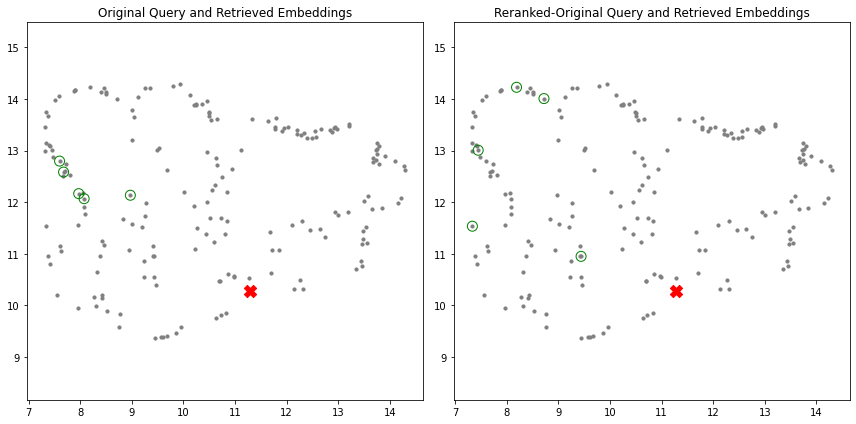

In [149]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure(figsize=(12, 6))

# Subplot for the original query and retrieved embeddings
plt.subplot(1, 2, 1)
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.gca().set_aspect('equal', 'datalim')
plt.title('Original Query and Retrieved Embeddings')

# Subplot for the augmented query embeddings
plt.subplot(1, 2, 2)
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings_rerank[:, 0], projected_retrieved_embeddings_rerank[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.gca().set_aspect('equal', 'datalim')
plt.title('Reranked-Original Query and Retrieved Embeddings')

plt.tight_layout()
plt.show()

In [158]:
print(query)
print('------------------------')
print('NON RERANKER RESPONSE')
print(response)
print('------------------------')
print('RERANKER RESPONSE')
print(response_reranked)

tell me about hobbies of author
------------------------
NON RERANKER RESPONSE
  Based on the provided text, the author has traveled to the following cities:

1. Mumbai
2. Pondicherry
3. Chennai
4. Lonavala
5. Mumbai (twice)
6. Bombay (twice)
7. Pune

Note: The author has mentioned these cities in their text, but it is not clear if they have traveled to all of these cities personally or if they are just mentioning them in their text.
------------------------
RERANKER RESPONSE
  Based on the provided text, the author has traveled to the following cities:

1. Bangalore
2. Chennai
3. Mumbai
4. Pondicherry
5. Mahindra World City
6. Zuca (mentioned as a chocolate shop)
7. Promenade
8. Mahabalipura (mentioned as a lunch spot)

These cities are mentioned in the text as places the author has visited or driven through during their trips.
